In [3]:
import sys
sys.path.insert(0, '../../')

In [4]:
from run_matching import predict
from run_matching import classification_report_to_table
from py3.auxilary3 import Helper as hp
import pandas as pd
import numpy as np

/Users/israelsofer/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


importing
!


In [5]:
host='REPLICA'
db_con = hp.DbExplorer(host)

In [6]:
# The columns we want to analyze and report
columns = ['serving_type_id', 'volume_id', 'brand_id']

In [7]:
# Get the test set for beer from the DB

In [8]:
time_condition = "and date(bp.inserted_at) between '2018-07-01'and '2018-09-01'"

In [9]:
query = """SELECT bp.id,
                bp.bar_id,
                a.country as country_id,
                bp.title,
                bp.price,
                COALESCE(units_in_pack,1) as units_in_pack,
                a.is_bulk
            FROM pos_bars_products bp
            JOIN pos_products pp on pp.id = bp.product_id 
            JOIN pos_products_brands pb on pb.product_id = pp.id
            JOIN bars a ON a.id = bp.bar_id
            WHERE bp.category_id = 1
            and pp.id != 0 """ + time_condition

In [10]:
test_list = db_con.dbreader(query)
len(test_list)

134831

In [11]:
test_df = pd.DataFrame(test_list)
print(test_df.shape)
test_df.head()

(134831, 7)


bar_id country_id         id  is_bulk  price          title  units_in_pack
0   7052.0     Canada  3091896.0      0.0   4.87            Bud            1.0
1  11994.0  Australia  3112123.0      0.0  13.00         Budvar            1.0
2   5245.0     Canada  3114729.0      0.0   4.35      BUDWEISER            1.0
3   3949.0     Canada  3115439.0      0.0   4.35            BUD            1.0
4  11520.0     Canada  3115765.0      0.0   4.95  BTL Budweiser            1.0

In [12]:
test_df = predict(host, test_df)

(134831, 7)
Loading model 0
Predicting items for cat 0
134831/134831 [==============================] - 131s 971us/step
Loading model 1
Predicting items for cat 1
118551/118551 [==============================] - 251s 2ms/step


In [13]:
query = """SELECT bp.id,
                bp.bar_id,
                pp.brand_id as brand_id_actual,
                pp.serving_type_id as serving_type_id_actual,
                pb.volume as volume_id_actual
            FROM pos_bars_products bp
            JOIN pos_products pp on pp.id = bp.product_id 
            JOIN pos_products_brands pb on pb.product_id = pp.id
            JOIN bars a ON a.id = bp.bar_id
            WHERE bp.category_id = 1
            and pp.id != 0 """ + time_condition

In [14]:
train_list = db_con.dbreader(query)
train_df = pd.DataFrame(train_list)
print(train_df.shape)
train_df = train_df[train_df['brand_id_actual'].notnull()]
print(train_df.shape)
train_df.head()

(134831, 5)
(134083, 5)


bar_id  brand_id_actual         id  serving_type_id_actual  \
0   7052.0             71.0  3091896.0                     1.0   
1  11994.0             71.0  3112123.0                     1.0   
2   5245.0             71.0  3114729.0                     1.0   
3   3949.0             71.0  3115439.0                     1.0   
4  11520.0             71.0  3115765.0                     1.0   

   volume_id_actual  
0             0.341  
1             0.341  
2             0.341  
3             0.341  
4             0.341

In [15]:
merged_df = train_df.merge(test_df, on=['id', 'bar_id'])
print('actual data size = ', train_df.shape, 'predict data size =', test_df.shape,
      'merged by pos_bar_product id data size =', merged_df.shape)

actual data size =  (134083, 5) predict data size = (118551, 19) merged by pos_bar_product id data size = (117907, 22)


In [16]:
merged_df['volume_id'] = merged_df['volume_id'].astype(str)
merged_df['volume_id_actual'] = merged_df['volume_id_actual'].astype(str)
merged_df['brand_id'] = merged_df['brand_id'].astype(str)
merged_df['brand_id_actual'] = merged_df['brand_id_actual'].astype(str)
merged_df['serving_type_id'] = merged_df['serving_type_id'].astype(str)
merged_df['serving_type_id_actual'] = merged_df['serving_type_id_actual'].astype(str)

In [17]:
merged_df[['brand_id', 'brand_id_actual']].drop_duplicates().head()

brand_id brand_id_actual
0       71.0            71.0
1     1259.0            71.0
62    1036.0            71.0
81      15.0            71.0
141     15.0            15.0

In [18]:
merged_df.columns

Index(['bar_id', 'brand_id_actual', 'id', 'serving_type_id_actual',
       'volume_id_actual', 'country_id', 'is_bulk', 'price', 'title',
       'units_in_pack', 'title_orig', 'country_orig', 'category_id',
       'category_id_prob', 'volume_id', 'type_id', 'superbrand_id', 'brand_id',
       'serving_type_id', 'brand_id_prob', 'serving_type_id_prob',
       'volume_id_prob'],
      dtype='object')

In [19]:
for column_name in columns:
    # print null value count
    print('prediction null values = ', sum(merged_df[column_name].isnull()))
    print('actual null values = ', sum(merged_df[column_name + '_actual'].isnull()))
    
    # remove all empty values
    merged_df.loc[merged_df[column_name + '_actual'].isnull(), column_name + 'actual'] = -1
    merged_df.loc[merged_df[column_name].isnull(), column_name] = -1

prediction null values =  0
actual null values =  0
prediction null values =  0
actual null values =  0
prediction null values =  0
actual null values =  0


In [20]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [21]:
def create_report(report_df, column_name):
    class_report = classification_report(report_df[column_name + '_actual'].astype(str), report_df[column_name], digits = 5)
    table_report = classification_report_to_table(class_report)
    table_report[0][0] = column_name
    avg_index = table_report.shape[0]-1
    df_class_report = pd.DataFrame(table_report[avg_index:avg_index+1], columns=table_report[0])
    return df_class_report

In [22]:
for column_name in columns:
    print(column_name)
    threshold = 0.85
    report_df = merged_df[(merged_df[column_name + '_prob'] > threshold)]
    print('auto matched items - above threshold', threshold, 'is', report_df.shape[0], 
          'out of', merged_df.shape[0], 'with ratio =', report_df.shape[0]/merged_df.shape[0])
    print('The accuracy =', accuracy_score(report_df[column_name + '_actual'], report_df[column_name]))
    print('average sub-classes f1 score')
    print('----------------------------')
    print(create_report(report_df, column_name))

serving_type_id
auto matched items - above threshold 0.85 is 102663 out of 117907 with ratio = 0.8707116625815261
The accuracy = 0.9063148359194646
average sub-classes f1 score
----------------------------


/Users/israelsofer/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


   serving_typ precision   recall f1-score support
0  avg / total   0.90519  0.90631  0.90549  102663
volume_id
auto matched items - above threshold 0.85 is 38934 out of 117907 with ratio = 0.3302094023255617
The accuracy = 0.8124261570863512
average sub-classes f1 score
----------------------------


/Users/israelsofer/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


     volume_id precision   recall f1-score support
0  avg / total   0.81185  0.81243  0.79267   38934
brand_id
auto matched items - above threshold 0.85 is 85603 out of 117907 with ratio = 0.7260213558143283
The accuracy = 0.8911369928623997
average sub-classes f1 score
----------------------------
      brand_id precision   recall f1-score support
0  avg / total   0.90268  0.89114  0.88683   85603


In [23]:
# Show matching per country

In [24]:
countries = merged_df.country_id.unique().tolist()
countries.remove('Israel')


In [54]:
df_results =  pd.DataFrame(columns=['field_name', 'country_id', 'coverage', 'match_count' 'accuracy'])
#for column_name in columns:
#    print(column_name)
#merged_df[serving_type_id + '_actual'] = merged_df[column_name + '_actual'].astype(str)
#merged_df[column_name] = merged_df[column_name].astype(str)

for country in countries:
    country_df = merged_df[merged_df.country_id == country]
    report_df = country_df
    report_df = report_df[(report_df['serving_type_id_prob'] > 0.99)]
    report_df = report_df[(report_df['brand_id_prob'] > 0.99)]
    
    auto_matched = report_df.shape[0]
    coverage = auto_matched/country_df.shape[0]
    acc_score = accuracy_score(report_df[column_name + '_actual'], report_df[column_name])
    df_results = df_results.append({'field_name' : column_name, 
                                    'country_id' : country, 
                                    'coverage' : coverage, 
                                    'match_count' : auto_matched, 
                                    'accuracy' : acc_score}, ignore_index=True) 

In [55]:
df_results


field_name      country_id  coverage  match_countaccuracy  accuracy  \
0   brand_id          Canada  0.379488                  NaN  0.942726   
1   brand_id       Australia  0.331808                  NaN  0.953368   
2   brand_id  United Kingdom  0.317584                  NaN  0.843350   
3   brand_id   United States  0.299863                  NaN  0.985010   
4   brand_id       Argentina  0.337075                  NaN  0.855701   
5   brand_id           Korea  0.187926                  NaN  0.932642   

   match_count  
0       3911.0  
1      11966.0  
2       2030.0  
3      18345.0  
4        991.0  
5        193.0

AxesSubplot(0.125,0.125;0.775x0.755)


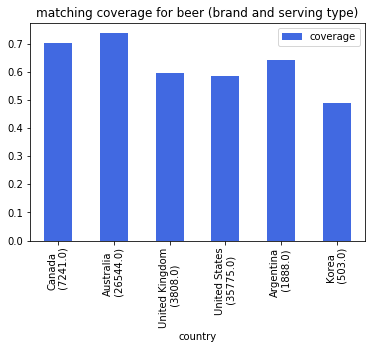

In [44]:
df_results['country'] =  df_results['country_id'].astype(str) + '\n (' + df_results['match_count'].astype(str) + ')'
print(df_results.plot.bar(x='country' , y=['coverage'], color='royalblue', title='matching coverage for beer (brand and serving type)'))


AxesSubplot(0.125,0.125;0.775x0.755)


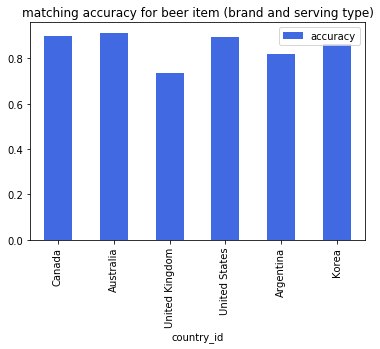

In [49]:
print(df_results.plot.bar(x='country_id', y=['accuracy'], color='royalblue', 
                          title='matching accuracy for beer item (brand and serving type)'))

In [21]:
merged_df.groupby(by=['serving_type_id', 'serving_type_id_actual'])['serving_type_id', 'serving_type_id_actual'].count()

serving_type_id  \
serving_type_id serving_type_id_actual                    
1.0             1.0                               25405   
                2.0                                4659   
                3.0                                 663   
                4.0                                 107   
                5.0                                   8   
                nan                                   1   
2.0             1.0                                3394   
                2.0                               46978   
                3.0                                 750   
                4.0                                   1   
                5.0                                  69   
3.0             1.0                                1221   
                2.0                                 346   
                3.0                                3662   
                4.0                                  17   
                5.0                                   7   

                                        serving_type_id_actual  
serving_type_id serving_type_id_actual                          
1.0             1.0                                      25405  
                2.0                                       4659  
                3.0                                        663  
                4.0                                        107  
                5.0                                          8  
                nan                                          1  
2.0             1.0                                       3394  
                2.0                                      46978  
                3.0                                        750  
                4.0                                          1  
                5.0                                         69  
3.0             1.0                                       1221  
                2.0                                        346  
                3.0                                       3662  
                4.0                                         17  
                5.0                                          7

In [22]:
a = merged_df.groupby(by=['brand_id', 'brand_id_actual'])['id'].count().reset_index(name='occur_counts')
a[(a.brand_id != a.brand_id_actual) & (a.occur_counts > 50)]

brand_id brand_id_actual  occur_counts
271    1055.0          9870.0           152
421   11043.0          6612.0            52
558    1213.0          2727.0           104
769    1429.0           429.0           249
781    1443.0           223.0           157
821      15.0            71.0           157
842    1509.0          1429.0           165
874     153.0          2743.0            71
1071   1709.0          1563.0            64
1280      2.0            71.0           119
1448   2041.0          2036.0            60
1480   2048.0          2047.0           558
1644   2092.0          2095.0           129
1666   2101.0          2100.0            53
1772   2143.0          2749.0            70
1853   2188.0          1563.0           103
1867    219.0          7704.0            84
1945    228.0           430.0            89
2113   2398.0          9870.0           110
2703      3.0           392.0           114
2838    318.0           433.0           172
3327   3880.0          9747.0           180
3542    416.0          6601.0           195
3637     43.0           429.0           209
3640     43.0           974.0            53
3667   4332.0          7461.0           104
3762    440.0          4609.0           148
3808    441.0          9791.0           151
3846    442.0          5966.0           200
4001    482.0           433.0           277
4034    488.0          9791.0           151
4337   5393.0          2063.0            52
4391   5528.0            26.0           145
4417   5550.0          7461.0            82
4732   5958.0          7461.0           101
4739   5966.0           442.0           570
4955   6447.0          9868.0           173
5270   7020.0           128.0            85
5466   7275.0          7482.0           117
5591   7607.0          7081.0            66
5944   8121.0           198.0            77
6018   8212.0          6312.0            74
6103    839.0          6312.0           100
6144    841.0          9498.0           169
6562   9224.0            84.0           291
6640   9521.0          2727.0           129
6644   9545.0          6923.0           312
6656   9608.0          6923.0           233
6685   9684.0          6923.0           140
6705    974.0          1429.0           421